In [30]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import random
import community as community_louvain

pd.set_option('display.max_columns', None)

## 1. Load the Data:

In [2]:
# Load the data
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
                "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
                "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv('data/kddcup.data.gz', header=None, names=column_names, compression='gzip')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


## 2. Remove Outliers

For simplicity, we'll use the IQR method to detect and remove outliers for the numerical columns:



In [3]:
# Define a function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

# List of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove outliers for each numerical column
for column in numerical_columns:
    df = remove_outliers(df, column)

In [4]:
df.shape

(2806165, 42)

Count how many NaN values there are overall in the dataset (All added in the remove outlier step):

In [5]:
df.isna().sum().sum()

0

Count how many rows have at leat one NaN value:

In [6]:
na_row_count = (df.isnull().sum(axis=1) > 0).sum()
print(na_row_count)

0


## 3. Normalization:

We'll use Min-Max scaling for normalization:

In [7]:
# Initialize the scaler
scaler = MinMaxScaler()

# Apply the scaler to the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## 4. Convert to Graph:

Let's proceed with the optimal graph construction for the KDD Cup 1999 dataset. We'll use the NetworkX library for this purpose, as it's user-friendly and suitable for this demonstration.

##### Initialize an Empty Graph:

In [8]:
# Initialize an Empty Graph
G = nx.Graph()

##### Add Nodes and Edges:

We'll represent each unique connection as a node and add edges based on shared attributes. For simplicity, we'll use protocol_type as the attribute to determine edges.

In [9]:
# Add nodes to the graph with protocol_type as an attribute
for index, row in df.iterrows():
    G.add_node(index, protocol_type=row['protocol_type'])


In [10]:
# Create a mapping of protocol_type to indices
protocol_mapping = df.groupby('protocol_type').apply(lambda x: x.index.tolist()).to_dict()

# Add edges based on the condition
for protocol, indices in protocol_mapping.items():
    for i in range(len(indices) - 1):
        # Check if the next connection is within the time window
        if indices[i + 1] - indices[i] <= 2:
            G.add_edge(indices[i], indices[i + 1])


## 5. Basic Graph Statistics

Before visualizing, it's helpful to understand some basic statistics about the graph.

In [12]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes()}")

Number of nodes: 2806165
Number of edges: 2806154
Average degree: 1.999992160118881


## 6. Visualize a Subgraph

Visualizing the entire graph might not be feasible or informative. Instead, I can visualize a subgraph. One way to extract a subgraph is to focus on nodes with a high degree (many connections).

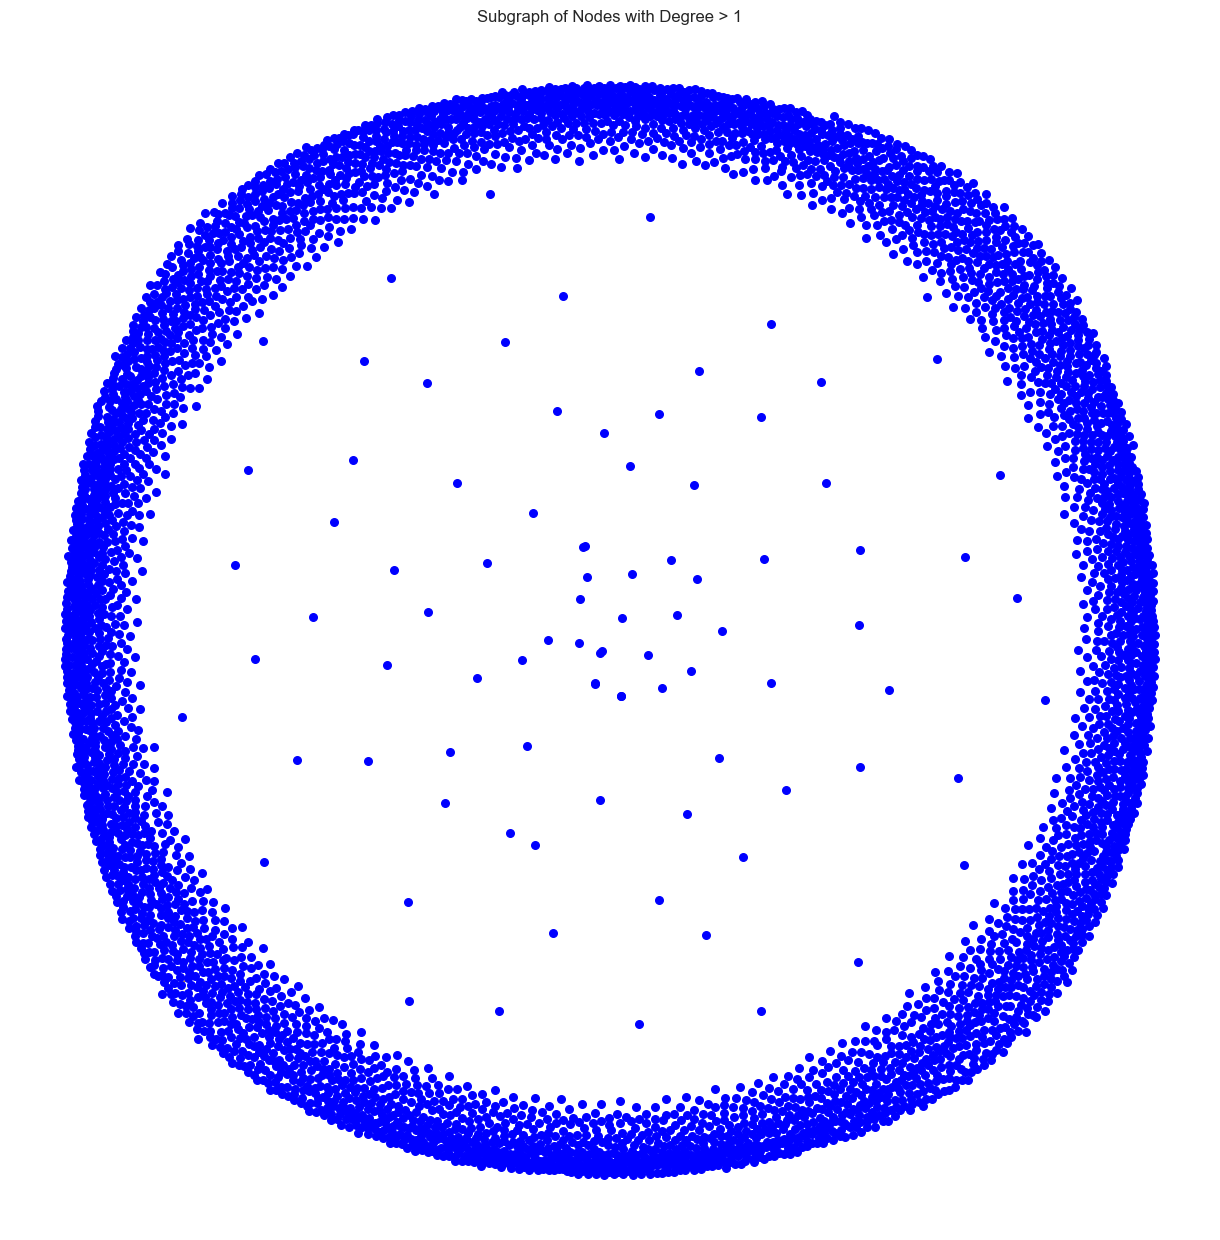

In [23]:
# Extract nodes with a degree higher than 1
higher_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree > 1]

# Randomly sample a subset of these nodes, say 1000 nodes
sampled_nodes = random.sample(higher_degree_nodes, 5000)
subgraph = G.subgraph(sampled_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, seed=42)  # Using a seed for reproducibility
nx.draw(subgraph, pos, with_labels=False, node_size=30, node_color='blue', edge_color='orange')
plt.title("Subgraph of Nodes with Degree > 1")
plt.show()

## 7. Degree Distribution:

Understanding the degree distribution can give insights into the network's structure.

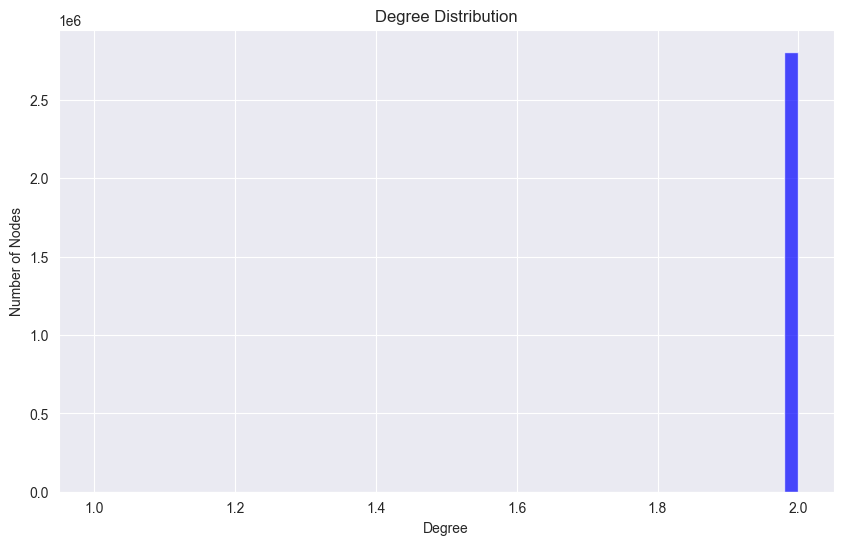

In [25]:
degrees = [G.degree(n) for n in G.nodes()]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

## 4. Analyze Clusters or Communities

Networks often have clusters or communities of nodes that are more densely connected with each other than with the rest of the network. The Louvain method is a popular method to detect these communities.

In [36]:
import community as community_louvain

# Now, try using the best_partition function
partition = community_louvain.best_partition(subgraph)

# Visualize the communities (only showing a subgraph for simplicity)
subgraph = G.subgraph(higher_degree_nodes)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=30, node_color=[partition[n] for n in subgraph.nodes()], cmap=plt.cm.RdYlBu, edge_color='orange')
plt.title("Communities in Subgraph")
plt.show()


AttributeError: module 'community' has no attribute 'best_partition'